In [287]:
import torch
import os
import re
import sys
import cv2
from config_reader import config_reader
import util
import numpy as np
from torch import nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from skimage.io import imread
from tqdm import tqdm
from scipy.ndimage.filters import gaussian_filter


In [95]:
from PoseEstimator import PoseEstimation

In [96]:
torch_device = torch.device('cuda:3')

## Dataloader

In [97]:
def prepare_image(img_path):
    param_, model_ = config_reader()

    oriImg = cv2.imread(img_path) # B,G,R order
    imageToTest = torch.FloatTensor(oriImg).permute((2,0,1))[None]
    multiplier = [x * model_['boxsize'] / oriImg.shape[0] for x in param_['scale_search']]

    heatmap_avg = torch.zeros((len(multiplier),19,oriImg.shape[0], oriImg.shape[1])).to(torch_device)
    paf_avg = torch.zeros((len(multiplier),38,oriImg.shape[0], oriImg.shape[1])).to(torch_device)

    scale = 1
    h = int(oriImg.shape[0]*scale)
    w = int(oriImg.shape[1]*scale)
    pad_h = 0 if (h%model_['stride']==0) else model_['stride'] - (h % model_['stride']) 
    pad_w = 0 if (w%model_['stride']==0) else model_['stride'] - (w % model_['stride'])
    new_h = h + pad_h
    new_w = w + pad_w

    imageToTest = cv2.resize(oriImg, (0,0), fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
    imageToTest_padded, pad = util.padRightDownCorner(imageToTest, model_['stride'], model_['padValue'])
    imageToTest_padded = np.transpose(np.float32(imageToTest_padded[:,:,:,np.newaxis]), (3,2,0,1))/256 - 0.5
    
    feed = torch.Tensor(imageToTest_padded)

    return feed

In [98]:
class CocoHuman(torch.utils.data.Dataset):
    def __init__(self, PATH, transform=None, mode='full', specify_index=None):
  
        self.PATH = PATH
        self.ids = []
        self.transform = transform
        self.Images = []
        self.Masks = []
        
        # load indexes
        if specify_index is None:
            specify_index = range(len(list(os.walk('./dataset/images/'))[0][2]))
          
        for j, id_ in  enumerate(list(os.walk('./dataset/images/'))[0][2]):
            if j in specify_index:
                self.ids.append(id_)
                
        self.len = len(self.ids)
         
        # load images and masks
        for id_ in tqdm(self.ids):
            Image = prepare_image('./dataset/images/' + id_)
            self.Images.append(Image)
            
            Mask = (imread('./dataset/masks/m_' + id_)[:,:,0] > 128).astype(np.uint8)
            Mask = torch.LongTensor(Mask)
            self.Masks.append(Mask)
            
            
    def __len__(self):
        return self.len
    
    
    def __getitem__(self, idx):      
        sample = {}
        sample['image'] = self.Images[idx]
        sample['mask'] = self.Masks[idx]
        
        if self.transform:
            sample = self.transform(sample)
            
        return sample        

In [278]:
train_dataset = CocoHuman('./Dataset', transform=None, specify_index=range(0,70))
test_dataset = CocoHuman('./Dataset', transform=None, specify_index=range(70,80))

100%|██████████| 10/10 [00:01<00:00,  7.66it/s]


## Transfer learning

In [100]:
# load trained model
model_mask = PoseEstimation.model(pretrained=True)
model_mask = model_mask.to(torch_device)
# model_mask.float()
# model_mask.eval();

In [101]:
model_mask.model6_1

Sequential(
  (0): Conv2d(185, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (1): ReLU(inplace)
  (2): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (3): ReLU(inplace)
  (4): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (5): ReLU(inplace)
  (6): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (7): ReLU(inplace)
  (8): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (9): ReLU(inplace)
  (10): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(128, 38, kernel_size=(1, 1), stride=(1, 1))
)

In [265]:
# freeze all layers
for param in model_mask.parameters():
    param.requires_grad = False

# edit output layer
model_mask.model6_1[12] = nn.Conv2d(in_channels=128, out_channels=2, kernel_size=1, stride=1, padding=0)

# train two layers
    
for param in model_mask.model6_1[10].parameters():
    param.requires_grad = True
    
for param in model_mask.model6_1[8].parameters():
    param.requires_grad = True
    
for param in model_mask.model6_1[6].parameters():
    param.requires_grad = True

model_mask = model_mask.to(torch_device)
model_mask.train();


In [266]:
loss = nn.CrossEntropyLoss()
loss = loss.to(torch_device)
grad_params = filter(lambda p: p.requires_grad, model_mask.parameters())
optimizer = torch.optim.Adam(grad_params,lr=0.001)

In [ ]:
epoch = 0
losses_train = []
losses_test = [0.]


for epoch in range(100):
    loss_epoch_train = []
    loss_epoch_test = []
    #print('train')

    for sample in train_dataset:
        image = sample['image'].to(torch_device)
        mask = sample['mask'].to(torch_device)

        prediction, _ = model_mask(image)
        prediction = nn.Upsample((mask.shape[0], mask.shape[1]), mode='bilinear', align_corners=True)(prediction)      

        loss_batch = loss(prediction, mask[None])
        loss_epoch_train.append(loss_batch.item())
        
        optimizer.zero_grad()
        loss_batch.backward()
        optimizer.step()
        
    losses_train.append(np.mean(loss_epoch_train))
        
    #print('test')
    for sample in test_dataset:
        
        image = sample['image'].to(torch_device)
        mask = sample['mask'].to(torch_device)

        prediction, _ = model_mask(image)
        prediction = nn.Upsample((mask.shape[0], mask.shape[1]), mode='bilinear', align_corners=True)(prediction)      

        loss_batch = loss(prediction, mask[None])
        loss_epoch_test.append(loss_batch.item())
    
    losses_test.append(np.mean(loss_epoch_test))
    
    sys.stdout.write('\r epoch {0:}, (Train / Test) : {1:.5} / {2:.5}'.format(epoch, losses_train[-1], losses_test[-1]))


 epoch 39, (Train / Test) : 0.043138 / 0.27279

In [279]:
torch.save(model_mask.state_dict(), './model/3.pth')

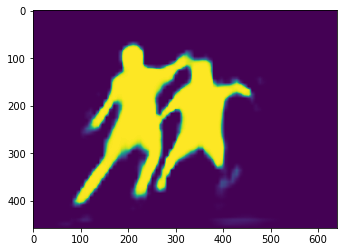

In [281]:
pred = nn.Softmax(dim=1)(prediction)[0,1].cpu().data.numpy()
plt.imshow(pred)

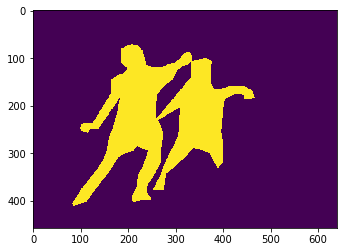

In [282]:
plt.imshow(mask)

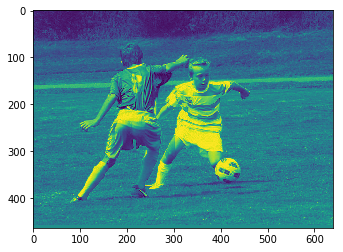

In [283]:
plt.imshow(image[0,0])

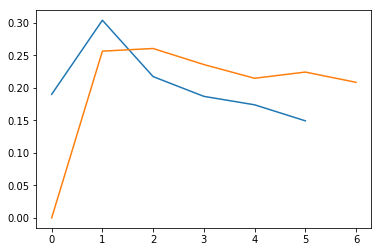

In [284]:
plt.plot(losses_train)
plt.plot(losses_test)

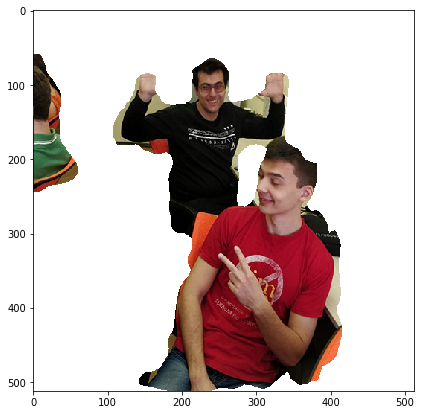

In [286]:
img_path = './sample_image/1.jpg'
img = plt.imread(img_path)

feed = prepare_image(img_path).to(torch_device)

prediction, _ = model_mask(feed)
prediction = nn.Upsample((img.shape[0], img.shape[1]), mode='bilinear', align_corners=True)(prediction)      
pred = nn.Softmax(dim=1)(prediction)[0,1].cpu().data.numpy()

alpha_pred = ((pred[:,:,None]>0.5)*255).astype(np.uint8)
plt.figure(figsize=(7,7))
plt.imshow(np.dstack([img, alpha_pred]))

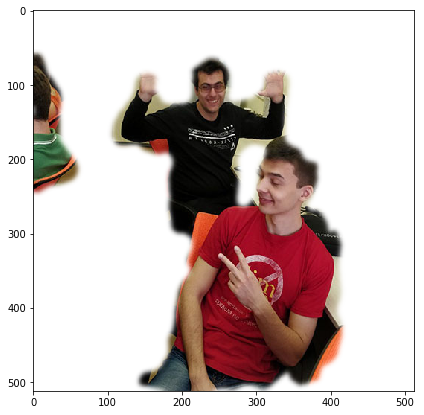

In [289]:
alpha_pred = ((pred[:,:,None]>0.5)*255).astype(np.uint8)
alpha_pred = gaussian_filter(alpha_pred, sigma=3)
plt.figure(figsize=(7,7))
plt.imshow(np.dstack([img, alpha_pred]))

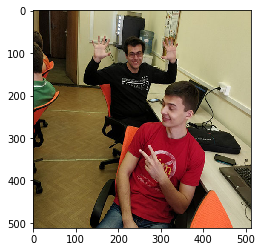

In [211]:
plt.imshow(img)

In [175]:
canvas = PoseEstimation.process_output(heatmap_avg, paf_avg, test_image)

NameError: name 'heatmap_avg' is not defined

In [ ]:
cv2.imwrite('result.png', canvas)   

In [321]:
plt.figure(figsize=(7,7))
b,g,r = cv2.split(canvas)
canvas_rgb = cv2.merge((r,g,b))
plt.imshow(canvas_rgb)

NameError: name 'canvas' is not defined